#### Loading in the data

In [131]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import plotly.graph_objects as go
from prophet import Prophet
from colorama import Fore
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [4]:
ticker = 'GC=F'  # Gold Futures ticker on Yahoo Finance
gold = yf.download(ticker, start='2016-01-01', end='2025-01-01', interval='1d')
gold.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [5]:
gold.to_csv('gold_prices_2016_2025.csv')

#### Checking the data


Removing the "ticker" row

In [6]:
gold.columns = gold.columns.droplevel(1)
gold.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [7]:
gold.describe()

Price,Close,High,Low,Open,Volume
count,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000
mean,1652.980317,1660.537551,1645.281999,1652.768554,5274.795223
std,383.260426,385.458997,380.943530,383.159313,29509.349030
min,1073.900024,1081.500000,1063.199951,1063.400024,0.000000
25%,1288.400024,1292.000000,1283.599976,1287.300049,47.000000
50%,1705.000000,1715.300049,1694.699951,1704.699951,181.000000
75%,1898.599976,1907.699951,1886.099976,1897.300049,560.000000
max,2788.500000,2789.000000,2774.600098,2787.399902,386334.000000


In [8]:
gold.dtypes

Price
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Checking for missing values

In [9]:
gold.isnull().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

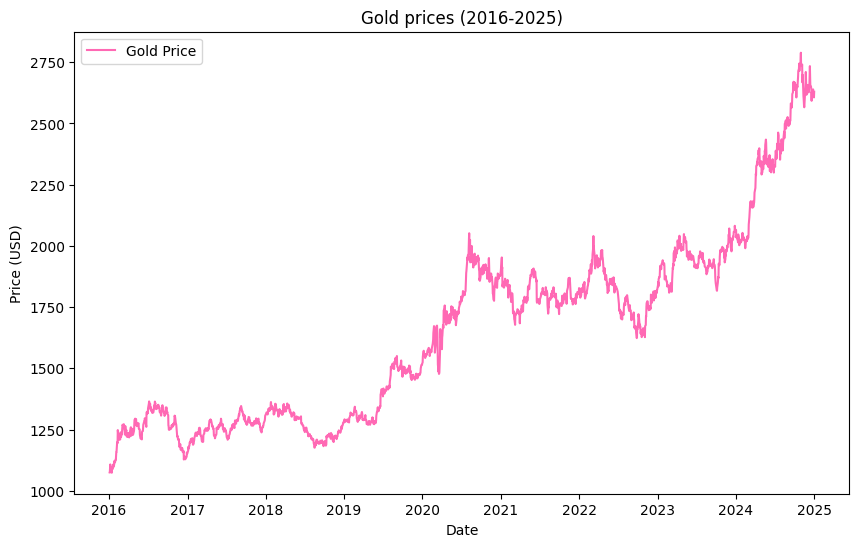

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(gold['Close'], label='Gold Price', color='hotpink')
plt.title('Gold prices (2016-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Checking outliers

In [11]:
gold['z_score'] = zscore(gold['Close'])
outliers = gold[gold['z_score'].abs() > 3]
print("Outliers detected:", outliers)

Outliers detected: Empty DataFrame
Columns: [Close, High, Low, Open, Volume, z_score]
Index: []


In [12]:
gold = gold[['Close']]
gold.head()

Price,Close
Date,
2016-01-04,1075.099976
2016-01-05,1078.400024
2016-01-06,1091.900024
2016-01-07,1107.699951
2016-01-08,1097.800049


#### Checking stationarity

In [13]:
adf_test = adfuller(gold['Close'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: 0.12059219759182055
p-value: 0.9674392205479142
Critical values: {'1%': np.float64(-3.433248072725654), '5%': np.float64(-2.8628202931061955), '10%': np.float64(-2.567451559747925)}
Fail to reject the null hypothesis - series is non-stationary


In [14]:
gold['Close_Diff'] = gold['Close'].diff()
gold['Close_Log'] = np.log(gold['Close'])
gold['Close_Log_Diff'] = gold['Close_Log'].diff()

# Drop NaN values caused by differencing
gold.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)

In [15]:
series_list = {
    'Close_Diff': gold['Close_Diff'],
    'Close_Log': gold['Close_Log'],
    'Close_Log_Diff': gold['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 0.0
Close_Log is non-stationary, with p-value: 0.9029816332621483
Close_Log_Diff is stationary, with p-value: 0.0


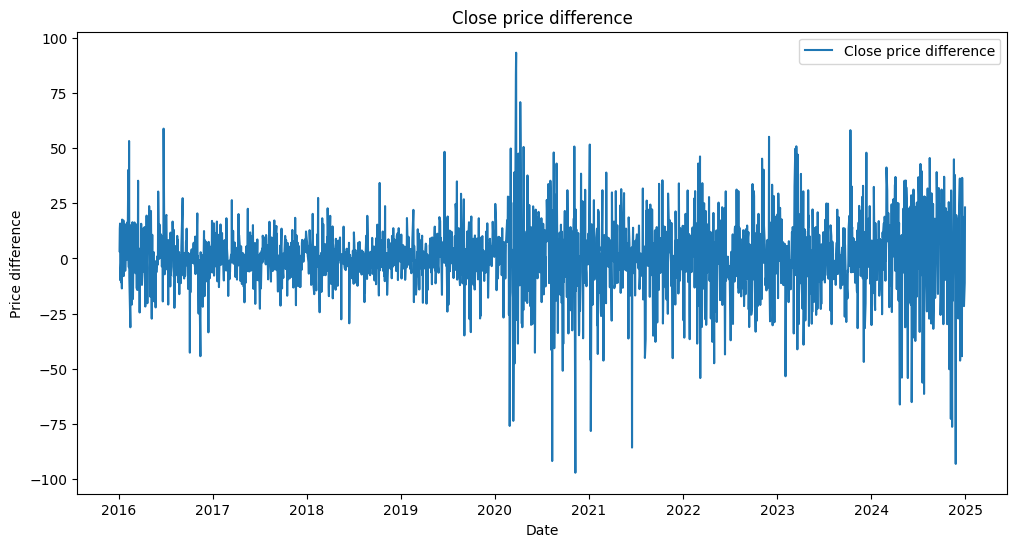

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(gold['Close_Diff'], label='Close price difference')
plt.title('Close price difference')
plt.xlabel('Date')
plt.ylabel('Price difference')
plt.legend()
plt.show()

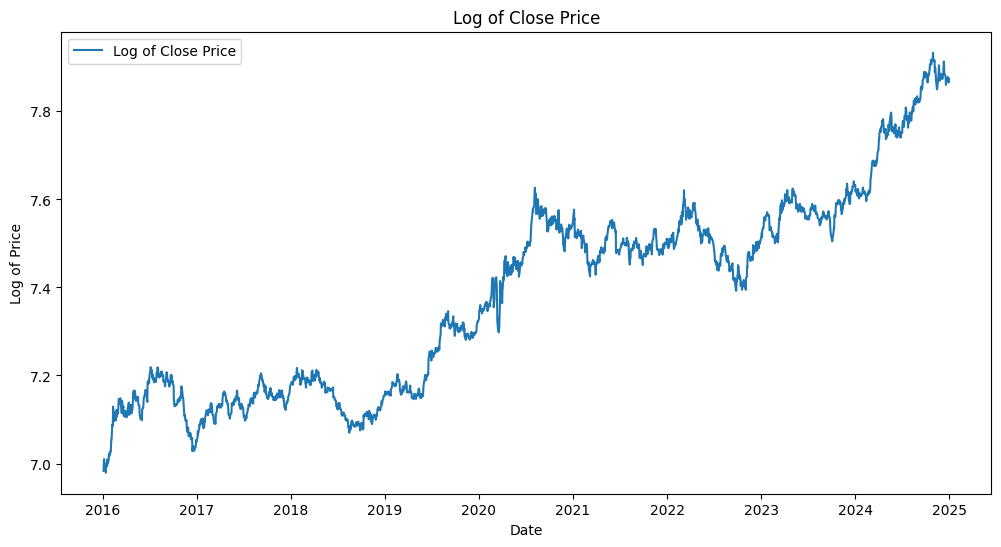

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(gold['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

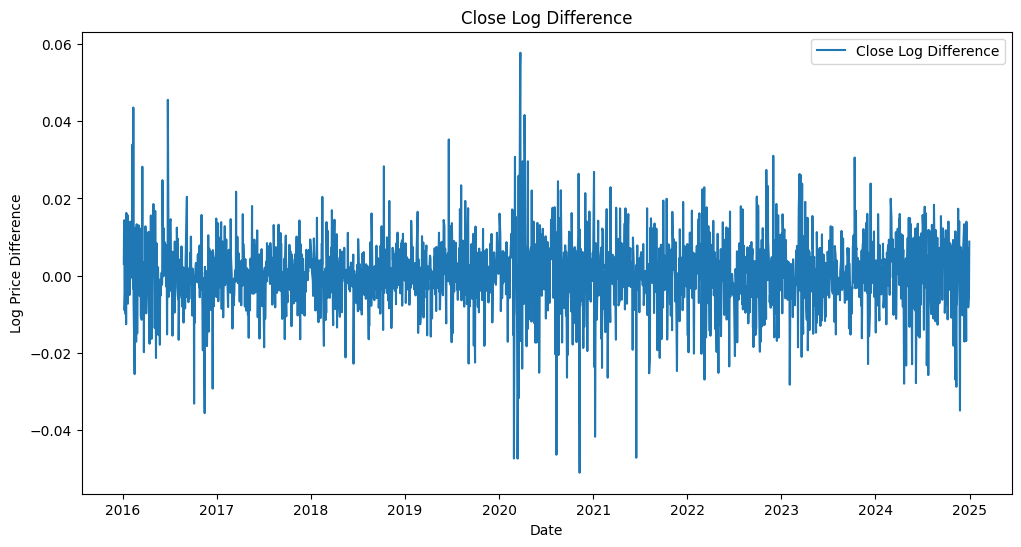

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(gold['Close_Log_Diff'], label='Close Log Difference')
plt.title('Close Log Difference')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')
plt.legend()
plt.show()

In [19]:
gold.head()

Price,Close,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065
2016-01-06,1091.900024,13.500000,6.995675,0.012441
2016-01-07,1107.699951,15.799927,7.010041,0.014366
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978
2016-01-11,1096.500000,-1.300049,6.999879,-0.001185


#### Moving Average

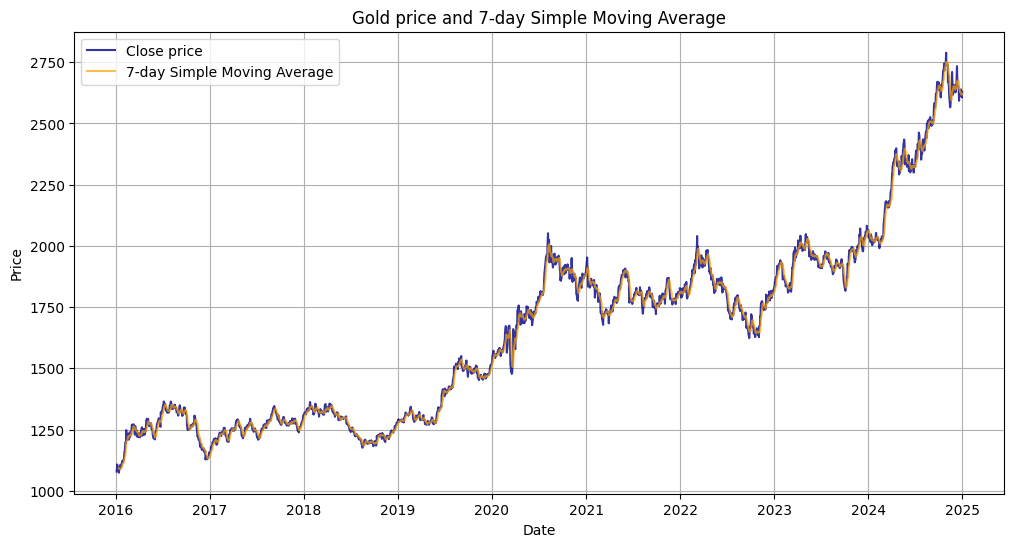

In [20]:
gold['SMA_7'] = gold['Close'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(gold['Close'], label='Close price', color='darkblue', alpha=0.8)
plt.plot(gold['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Gold price and 7-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


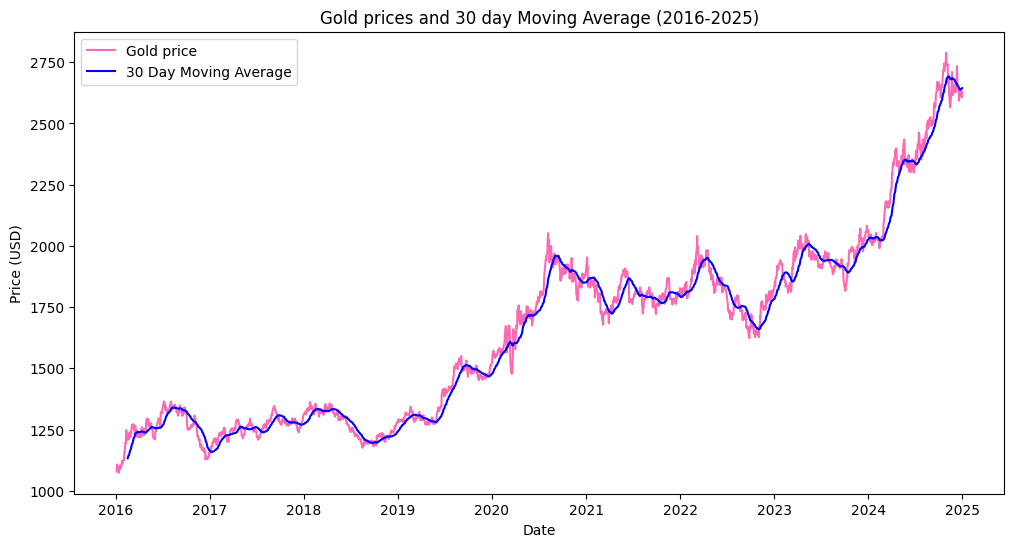

In [21]:
gold['30_day_MA'] = gold['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(gold['Close'], label='Gold price', color='hotpink')
plt.plot(gold['30_day_MA'], label='30 Day Moving Average', color='blue')
plt.title('Gold prices and 30 day Moving Average (2016-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#### Decomposition

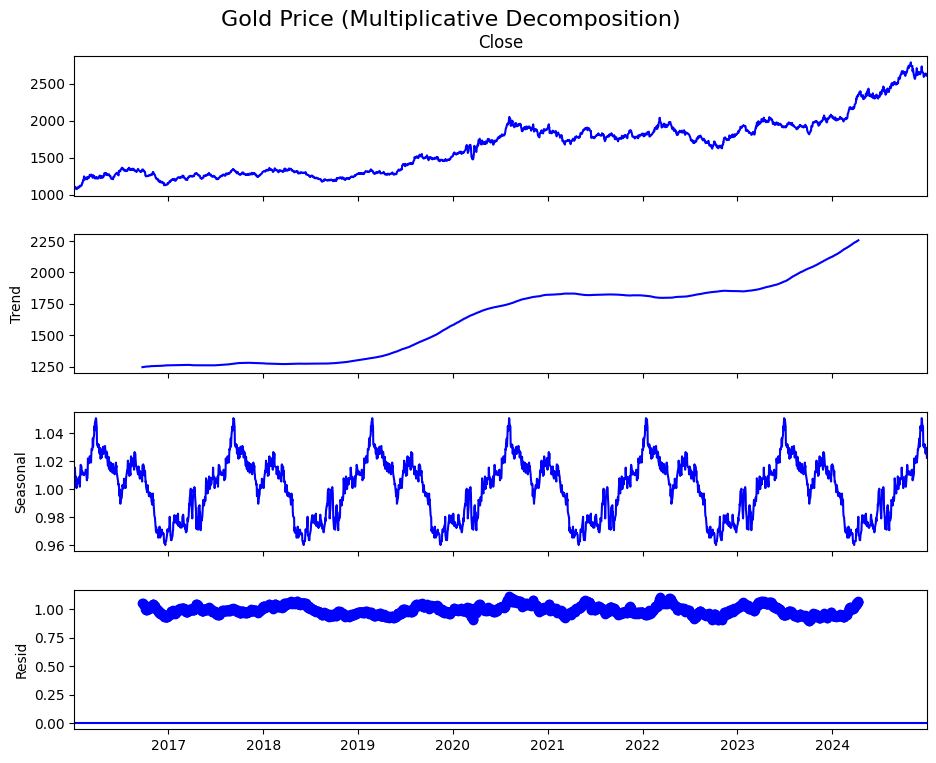

In [22]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    for ax in fig.axes:
        for line in ax.get_lines():
            line.set_color(plot_color)
    plt.show()

plot_decomposition(gold['Close'], model='multiplicative', period=365, title="Gold Price (Multiplicative Decomposition)", plot_color='blue')

#### Arima

In [189]:
df_arima = gold.copy()
df_arima

Price,Close,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,30_day_MA
Date,,,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065,NaN,NaN
2016-01-06,1091.900024,13.500000,6.995675,0.012441,NaN,NaN
2016-01-07,1107.699951,15.799927,7.010041,0.014366,NaN,NaN
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978,NaN,NaN
2016-01-11,1096.500000,-1.300049,6.999879,-0.001185,NaN,NaN
...,...,...,...,...,...,...
2024-12-24,2620.000000,7.699951,7.870930,0.002943,2626.499965,2638.016667
2024-12-26,2638.800049,18.800049,7.878080,0.007150,2624.699986,2639.310002
2024-12-27,2617.199951,-21.600098,7.869860,-0.008219,2620.814279,2640.523332


In [190]:
df_arima.drop(columns=['Close', 'Close_Diff', 'Close_Log', 'SMA_7',	'30_day_MA'], inplace=True)
df_arima

Price,Close_Log_Diff
Date,
2016-01-05,0.003065
2016-01-06,0.012441
2016-01-07,0.014366
2016-01-08,-0.008978
2016-01-11,-0.001185
...,...
2024-12-24,0.002943
2024-12-26,0.007150
2024-12-27,-0.008219


In [191]:
train_size = int(len(df_arima) * 0.8)  
train, test = df_arima.iloc[:train_size], df_arima.iloc[train_size:]

In [192]:
rolmean = df_arima.rolling(20).mean()
rolstd = df_arima.rolling(20).std()

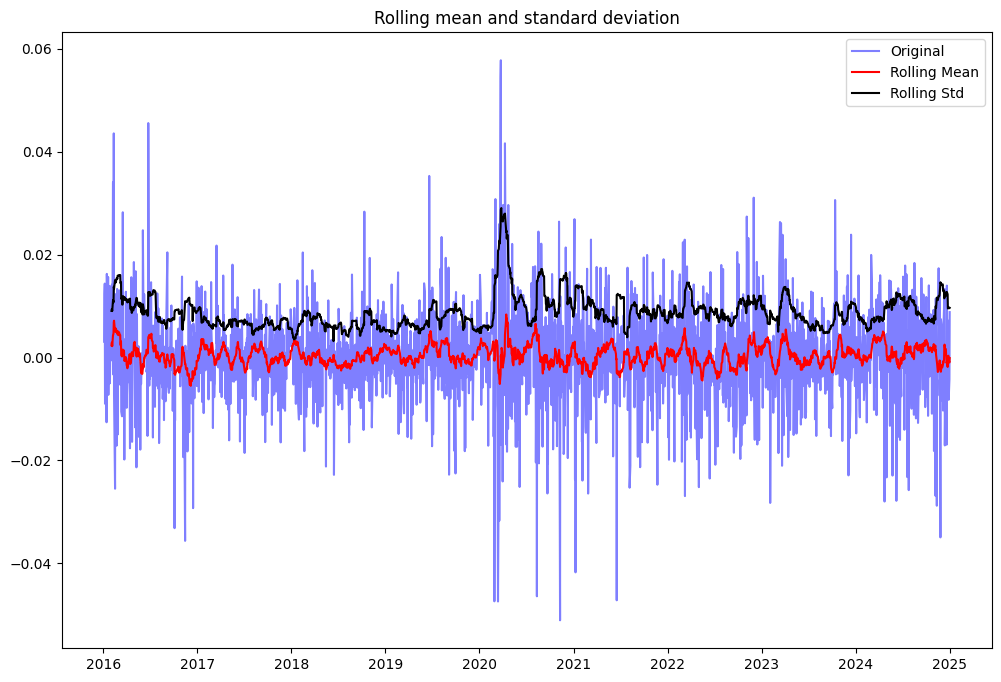

In [193]:
plt.figure(figsize=(12,8))
orig = plt.plot(df_arima, color = 'blue', label = 'Original', alpha=0.5)
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label= "Rolling Std")
plt.title("Rolling mean and standard deviation")
plt.legend(loc='best')
plt.show()

In [194]:
#perform Dickey-fuller test

dftest = sm.tsa.adfuller(df_arima, autolag="AIC")
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Obs. Used'])

for key, value in dftest[4].items():
    dfoutput["Critical Value ({0})".format(key)] = value


dfoutput

Test Statistic           -20.694640
p-value                    0.000000
#Lags Used                 5.000000
Number of Obs. Used     2254.000000
Critical Value (1%)       -3.433255
Critical Value (5%)       -2.862823
Critical Value (10%)      -2.567453
dtype: float64

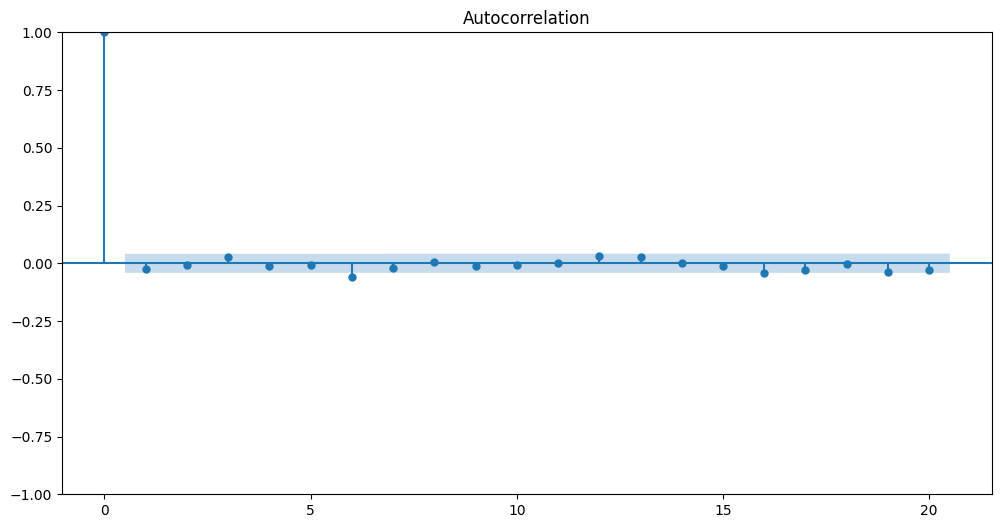

In [195]:
fig,ax = plt.subplots(figsize=(12,6))
plot_acf(df_arima.values, lags=20, ax=ax)
plt.show()

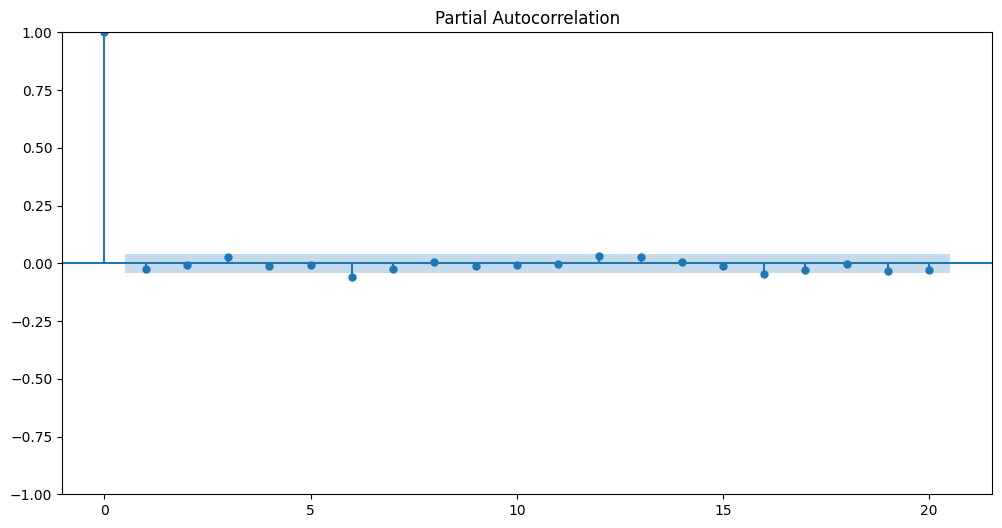

In [196]:
fig,ax = plt.subplots(figsize=(12,6))
plot_pacf(df_arima.values, lags=20, ax=ax)
plt.show()

In [ ]:
# Fit ARIMA model
model = ARIMA(train, order=(3, 1, 3))
model_fit = model.fit()
forecasts_arima = model_fit.forecast(steps=len(test))

In [198]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Close_Log_Diff   No. Observations:                 1808
Model:                 ARIMA(3, 1, 3)   Log Likelihood                5859.614
Date:                Wed, 22 Jan 2025   AIC                         -11705.229
Time:                        01:24:34   BIC                         -11666.733
Sample:                             0   HQIC                        -11691.021
                               - 1808                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3950      0.028    -50.663      0.000      -1.449      -1.341
ar.L2         -0.9765      0.032    -30.993      0.000      -1.038      -0.915
ar.L3         -0.0236      0.018     -1.316      0.188      -0.059       0.012
ma.L1          0.4205      0.022     19.306      0.000       0.378       0.463
ma.L2         -0.3667      0.019    -19.750      0.000      -0.403      -0.330
ma.L3         -0.9293      0.022    -41.422      0.000      -0.973      -0.885
sigma2      8.909e-05   1.83e-06     48.775      0.000    8.55e-05    9.27e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):              1568.74
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

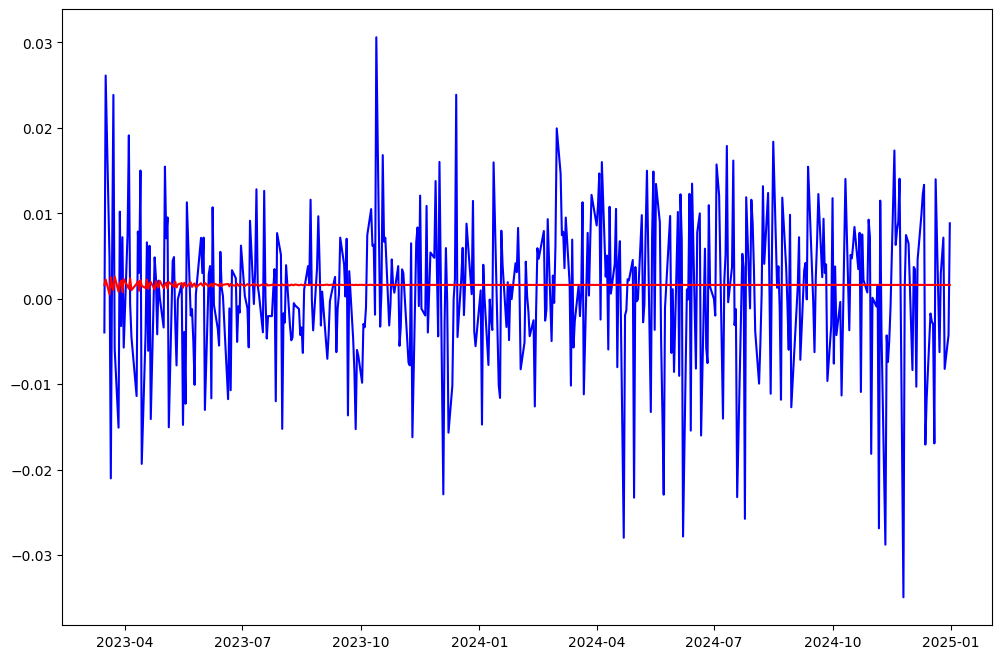

In [199]:
plt.figure(figsize=(12,8))
plt.plot(test.index, test, color = 'blue')
plt.plot(test.index, forecasts_arima, color='red')
plt.show()

In [182]:
mse = mean_squared_error(test['Close_Log_Diff'], forecasts_arima)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 7.969630993829633e-05
